In [1]:
## widen the cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import numpy as np
from typing import Union
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from collections import defaultdict
from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_auto

%matplotlib inline

In [3]:
def shermanMorrison(V:np.ndarray, x:np.ndarray):
    """
    ${V_t}^{-1} = V_{t-1}^{-1} - \frac{V_{t-1}^{-1}xx^T V_{t-1}^{-1}}{1 + x^T V_{t-1}^{-1} x}$
    V: inverse of old gram matrix, corresponding to $V_{t-1}$.
    x: a new observed context
    return: inverse of new gram matrix
    """
    numerator = np.einsum("ij, j, k, kl -> il", V, x, x, V)
    denominator = (1 + np.einsum("i, ij, j ->", x, V, x))
    return V - (numerator / denominator)


def l2norm(v:np.ndarray):
    v = v.flatten()
    return np.sqrt(np.sum(v ** 2))


def covariance_generator(d:int, distribution:str="gaussian", bound:float=None):
    if distribution == "gaussian":
        rnd = np.random.randn(d, d)
    elif distribution == "uniform":
        rnd = np.random.uniform(-1, 1, size=d*d).reshape(d, d)
    
    ## make a symmetric matrix
    sym = (rnd + rnd.T) / 2
    ## make positive semi-definite and bound its maximum singular value
    mat = sym @ sym.T
    
    if bound is not None:
        mat *= (bound / np.linalg.norm(mat, 2))
    
    return mat


# Function for Gram-Schmidt process
def gram_schmidt(A):
    Q = np.zeros(A.shape)
    for i in range(A.shape[1]):
        # Orthogonalize the vector
        Q[:,i] = A[:,i]
        for j in range(i):
            Q[:,i] -= np.dot(Q[:,j], A[:,i]) * Q[:,j]
        
        # Normalize the vector
        Q[:,i] = Q[:,i] / np.linalg.norm(Q[:,i])
    return Q


def make_diagonal(v:np.ndarray, dim:Union[int, tuple]):
    if type(dim) == int:
        diag = np.zeros((dim, dim))
        rng = dim
    else:
        diag = np.zeros(dim)
        rng = min(dim)
        
    for i in range(rng):
        diag[i, i] = v[i]
    
    return diag


def positive_definite_generator(dimension:int, distribution:str="uniform"):
    d = dimension
    ## create orthogonal eigenvectors
    source = np.random.uniform(-1, 1, size=(d*d)).reshape(d, d)
    eigvecs = gram_schmidt(source)
    
    ## create a matrix of eigenvalues
    eigvals = np.random.uniform(0, 1, size=d)
    eigmat = make_diagonal(np.absolute(eigvals))
    
    ## make the targeted positive definite matrix
    Z = source @ eigmat @ source.T
    return Z


def minmax(v:np.ndarray, bound:float=1.):
    min = np.min(v)
    max = np.max(v)
    return ((v - min) / (max - min)) * bound


def left_pseudo_inverse(A:np.ndarray):
    d, k = A.shape
    u, A_sig, v_T = np.linalg.svd(A)
    
    B_sig = np.zeros((k, d))
    for i in range(k):
        B_sig[i, i] = 1 / A_sig[i]
    
    B = v_T.T @ B_sig @ u.T
    
    return B


def rademacher(size:int):
    """
    Generate Rademacher random variables.

    Args:
    size (int): Number of random variables to generate.

    Returns:
    numpy.ndarray: An array of Rademacher random variables.
    """
    return 2 * np.random.randint(0, 2, size) - 1


def subgaussian_noise(distribution:str, size:int, random_state:int=None, std:float=None):
    """
    distribution (str): the distribution to sample a sub-Gaussian noise
    size (int): The number of total rounds (T)
    std (float): The variance proxy of the noise
    """
    if random_state:
        np.random.seed(random_state)
    if not std:
        assert distribution in ["gaussian", "uniform"]
    
    if distribution == "gaussian":
        if not std:
            std = 1
        noise = np.random.normal(loc=0, scale=std, size=size) 
    elif distribution == "uniform":
        if not std:
            low = -1
            high = 1
            std = np.sqrt(((high - low) ** 2) / 12)
        else:
            low = -np.sqrt(3) * std
            high = np.sqrt(3) * std
        noise = np.random.uniform(low=low, high=high, size=size)
    else:
        std = 1
        noise = rademacher(size=size)
    return noise, std

In [4]:
def feature_sampler(dimension:int, feat_dist:str, size:int, disjoint:bool, random_state:int, cov_dist:str=None, bound:float=None, uniform_rng:list=None):
    np.random.seed(random_state)
    assert feat_dist.lower() in ["gaussian", "uniform"]
    
    if disjoint:
        if feat_dist.lower() == "gaussian":
            assert uniform_rng is None, f"If the distribution is {distribution}, variable range is not required."
            ## gaussian
            feat = np.random.multivariate_normal(mean=np.zeros(dimension), cov=np.identity(dimension), size=size)
        else:
            ## uniform
            if not uniform_rng:
                ## if the range for the uniform distribution is not specified
                low, high = -1., 1.
            else:
                low, high = uniform_rng
            feat = np.random.uniform(low=low, high=high, size=size*dimension).reshape(size, dimension)
    else:
        assert cov_dist is not None, f"If 'disjoint' is set to {disjoint}, it is required to specify the distribution to sample the covariance matrix."
        if feat_dist.lower() == "gaussian":
            assert uniform_rng is None, f"If the distribution is {distribution}, variable range is not required."
            ## gaussian
            cov = covariance_generator(dimension, distribution=cov_dist)
            feat = np.random.multivariate_normal(mean=np.zeros(dimension), cov=cov, size=size)
        else:
            ## uniform
            if not uniform_rng:
                ## if the range for the uniform distribution is not specified
                low, high = -1., 1.
            else:
                low, high = uniform_rng
            feat = np.random.uniform(low=low, high=high, size=size*dimension).reshape(size, dimension)
            
            # Cholesky decomposition
            pd = positive_definite_generator(dimension, distribution=cov_dist)
            L = np.linalg.cholesky(pd)
            for i in range(size):
                feat[i, :] = L @ feat[i, :]
            
    if bound is not None:
        ## bound the L2 norm of each row vector
        norms = [l2norm(feat[i, :]) for i in range(size)]
        max_norm = np.max(norms)
        for i in range(size):
            feat[i, :] *= (bound / max_norm)
    
    return feat


def mapping_generator(latent_dim:int, obs_dim:int, distribution:str, random_state:int, bound:float=None, uniform_rng:list=None):
    np.random.seed(random_state)
    assert distribution.lower() in ["gaussian", "uniform"]
    
    if distribution.lower() == "gaussian":
        assert uniform_rng is None, f"If the distribution is {distribution}, variable range is not required."
        mat =  np.random.randn(latent_dim, obs_dim)
    else:
        if not uniform_rng:
            low, high = -np.sqrt(2/latent_dim), np.sqrt(2/latent_dim)
        else:
            low, high = uniform_rng
        mat = np.random.uniform(low=low, high=high, size=latent_dim*obs_dim).reshape(latent_dim, obs_dim)
        
    if bound:
        ## constrain the lower bound
        u, sig, v_T = np.linalg.svd(mat)
        sig = sig - np.min(sig) + bound
        sig_mat = make_diagonal(sig, dim=mat.shape)
        mat = u @ sig_mat @ v_T

    return mat


def param_generator(dimension:int, distribution:str, disjoint:bool, random_state:int, bound:float=None, uniform_rng:list=None):
    np.random.seed(random_state)
    assert distribution.lower() in ["gaussian", "uniform"]
    
    if disjoint:
        if distribution == "gaussian":
            assert uniform_rng is None, f"If the distribution is {distribution}, variable range is not required."
            param = np.random.randn(dimension)
        else:
            if not uniform_rng:
                low, high = -1., 1.
            else:
                low, high = uniform_rng
            param = np.random.uniform(low=low, high=high, size=dimension)
    else:
        if distribution == "gaussian":
            assert uniform_rng is None, f"If the distribution is {distribution}, variable range is not required."
            cov = covariance_generator(dimension, distribution=distribution)
            param = np.random.multivariate_normal(mean=np.zeros(dimension), cov=cov)
        else:
            # uniform
            if not uniform_rng:
                low, high = -1., 1.
            else:
                low, high = uniform_rng
            param = np.random.uniform(low=low, high=high, size=dimension)
            pd = positive_definite_generator(dimension, distribution=distribution)
            L = np.linalg.cholesky(pd)
            param = L @ param
        
    if (bound is not None) and (l2norm(param) > bound): 
        param *= (bound / l2norm(param))
    
    return param

In [5]:
## Agent
class ContextualBandit(ABC):
    @abstractmethod
    def choose(self, x): pass
    
    @abstractmethod
    def update(self, x, r): pass

In [6]:
class LinUCB(ContextualBandit):
    def __init__(self, d, alpha, lbda=1.):
        self.alpha = alpha
        self.t = 0
        self.xty = np.zeros(d)
        self.Vinv = (1 / lbda) * np.identity(d)
        
    def choose(self, x):
        # x: action set at each round (N, d)
        self.t += 1
        
        ## compute the ridge estimator
        theta_hat = self.Vinv @ self.xty
        
        ## compute the ucb scores for each arm
        expected = x @ theta_hat # (N, ) theta_T @ x_t
        width = np.sqrt(np.einsum("Ni, ij, Nj -> N", x, self.Vinv, x) * np.log(self.t)) # (N, ) widths
        ucb_scores = expected + (self.alpha * width) # (N, ) ucb score
        
        ## chose the argmax the ucb score
        maximum = np.max(ucb_scores)
        argmax, = np.where(ucb_scores == maximum)
        
        return np.random.choice(argmax)
    
    def update(self, x, r):
        # x: context of the chosen action (d, )
        self.Vinv = shermanMorrison(self.Vinv, x)
        self.xty += (r * x)

# Partially related to the reward

In [7]:
class PartialLinUCB(ContextualBandit):
    def __init__(self, d, N, alpha, lbda=1.):
        """
        N: the number of arms
        """
        self.N = N
        self.alpha = alpha
        self.t = 0
        self.xty = np.zeros(d+N)
        self.Vinv = (1 / lbda) * np.identity(d+N)
        
    def choose(self, x):
        # x: action set at each round (N, d)
        self.t += 1
        
        ## compute the ridge estimator
        theta_hat = self.Vinv @ self.xty # (d+N, )
        
        ## concatenate a one-hot encoded matrix to make x from (N, d) to (N, d+N)
        onehot = np.identity(self.N)
        x = np.concatenate((x, onehot), axis=1)
        
        ## compute the ucb scores for each arm
        expected = x @ theta_hat # (N, ) theta_T @ x_t
        width = np.sqrt(np.einsum("Ni, ij, Nj -> N", x, self.Vinv, x) * np.log(self.t)) # (N, ) widths
        ucb_scores = expected + (self.alpha * width) # (N, ) ucb score
        
        ## chose the argmax the ucb score
        maximum = np.max(ucb_scores)
        argmax, = np.where(ucb_scores == maximum)
        
        return np.random.choice(argmax)
    
    def update(self, x, a, r):
        # x: context of the chosen action (d, )
        # a: index of the chosen action
        arm_index = np.zeros(self.N)
        arm_index[a] = 1.
        x = np.concatenate((x, arm_index), axis=0)
        
        self.Vinv = shermanMorrison(self.Vinv, x)
        self.xty += (r * x)

In [8]:
## hyper-parameters
M = 50000         # number of samples
N = 5             # number of actions in the action set at each round
d = 12            # observable dimension
k = 8             # latent dimension
m = 5             # number of visible elements to the reward function
T = int(1e5)      # total time horizon
SEED = 137        # random state

feature_bound = 1.
# matrix_lower_bound = 0.5  # lower bound of the decoder (inverse is the upper bound of the encoder)
matrix_bound = 1.
param_bound = 1.
reward_bound = 1.

ALPHAS = [0.0, 0.1, 0.3, 0.5, 1.0]
runtime = 4

## $Z \sim N(0, I_k), A={(a_{ij})}_{i\in [k], j\in[d]} \sim U\left(-\sqrt{\frac{2}{k}}, \sqrt{\frac{2}{k}}\right), \mu_i\in \boldsymbol{\mu_*}\sim U(-1, 1)$

In [9]:
## latent feature
Z = feature_sampler(dimension=k, feat_dist="gaussian", size=M, disjoint=True, random_state=SEED)
Z_norms = [l2norm(Z[i, :]) for i in range(M)]

print(f"Total action space shape: {Z.shape}")
print(f"First context: {Z[0, :]}")
print(f"Maximum norm: {np.max(Z_norms)}, Minimum norm: {np.min(Z_norms)}")

Total action space shape: (50000, 8)
First context: [ 1.09077549  1.06558071  4.51574031 -0.66767452 -0.40789271  0.9866497
  0.80106522  1.02688747]
Maximum norm: 6.229495682360592, Minimum norm: 0.46833084758651733


In [10]:
## decoder mapping
A = mapping_generator(latent_dim=k, obs_dim=d, distribution="uniform", random_state=SEED, bound=matrix_bound)
_, sing, _ = np.linalg.svd(A)

print(f"Mapping shape: {A.shape}")
print(f"{A}")
print(f"Lower bound: {np.min(sing)}")

Mapping shape: (8, 12)
[[ 0.70300531 -0.61844841  0.22113387  0.36889283 -0.01354187 -0.03952737
   0.62798065 -0.67562781  0.55145175 -0.22126274  0.89839534  0.44336493]
 [ 0.42336864  0.22912762  0.49702344 -0.8687593   0.44822358 -0.0263125
  -0.59329962  0.28204204  0.58789273  0.43571049  0.68275267 -0.22759327]
 [-0.34915944  0.60592072 -0.12668464 -0.36832377  0.17700825 -0.07516249
  -0.02590637  0.14552641  0.68877914  0.6205024   0.1703338   0.51667436]
 [-0.61730737 -0.71835562  0.0174265  -0.48122562 -0.09027716 -0.66491984
   0.54429711 -0.65528044 -0.06929177 -0.65608301 -0.37550594 -0.55049472]
 [-0.80160924 -0.60062081  0.85119512  0.30413054  0.30347346  0.42274904
   0.19488706 -0.54354798 -0.13197769  0.63172963  0.08674041 -0.33391235]
 [-0.01890017 -0.65773525  0.12818746  0.23955478 -0.55839273 -0.10598571
   0.36562172  0.54355211  0.57800659 -0.01828997 -0.48494711 -0.04552116]
 [-0.39197307  0.34986662 -0.21946125  0.12689664 -0.75939076  0.05290298
   0.67540

### $\sigma_{\eta} = \frac{1}{\sqrt{T}}, \eta_a^i\in\boldsymbol{\eta_a} \sim N\left(0, \sigma_\eta^2\right)$

In [11]:
context_noise, std = subgaussian_noise(distribution="gaussian", size=M*d, random_state=SEED, std=1/np.sqrt(T))
context_noise = context_noise.reshape(M, d)
print(f"Shape of context noise: {context_noise.shape}")
print(f"First context noise: {context_noise[0, :]}")

Shape of context noise: (50000, 12)
First context noise: [ 0.00344933  0.00336966  0.01428002 -0.00211137 -0.00128987  0.00312006
  0.00253319  0.0032473   0.00010399  0.00358783  0.00092478 -0.00254954]


In [12]:
## Generate X
X = Z @ A + context_noise

maxnorm = np.max([l2norm(X[i, :]) for i in range(M)])
for i in range(X.shape[0]):
    X[i, :] *= (feature_bound / maxnorm)

# for i in range(M):
#     norm = l2norm(X[i, :])
#     if norm > feature_bound:
#         X[i, :] *= (feature_bound / norm)

Xnorms = [l2norm(X[i, :]) for i in range(M)]

print(f"Shape of observable features: {X.shape}")
print(f"Observable features of the first arm: {X[0, :]}")
print(f"Maximum L2 norm: {np.max(Xnorms)}\tMinimum L2 norm: {np.min(Xnorms)}")

Shape of observable features: (50000, 12)
Observable features of the first arm: [ 0.03427902  0.24584408  0.05214674 -0.20718621 -0.00544738  0.02554538
  0.10127272  0.09467595  0.46422176  0.22528972  0.14956861  0.25607098]
Maximum L2 norm: 1.0	Minimum L2 norm: 0.05868540427503045


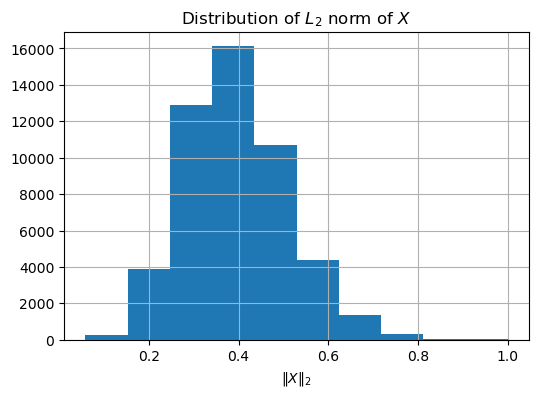

In [13]:
plt.figure(figsize=(6, 4))
plt.hist(Xnorms)
plt.grid(True)
plt.xlabel("${\Vert X \Vert}_2$")
plt.title("Distribution of $L_2$ norm of $X$")
plt.show()

### $\epsilon\sim N\left(0, \sigma_\epsilon^2\right), \sigma_\epsilon=0.1$

In [14]:
## reward parameter -> only m (m<=k) elements combies with features
true_param = param_generator(dimension=m, distribution="uniform", disjoint=True, random_state=SEED, bound=param_bound)
print(f"True reward parameter: {true_param}\tshape: {true_param.shape}\tnorm: {l2norm(true_param)}\n")

## generate the inherent reward for each arm
inherent_rewards = param_generator(dimension=N, distribution="uniform", disjoint=True, random_state=SEED)
print(f"Inherent reward for each arm: {inherent_rewards}\tshape: {inherent_rewards.shape}\tnorm: {l2norm(inherent_rewards)}")

True reward parameter: [ 6.65759812e-01 -6.17169589e-01  2.93049629e-01  2.99978545e-01
 -5.99468766e-04]	shape: (5,)	norm: 1.0

Inherent reward for each arm: [ 8.87700416e-01 -8.22911944e-01  3.90741935e-01  3.99980705e-01
 -7.99310297e-04]	shape: (5,)	norm: 1.3333643761349934


In [15]:
def run(agent:PartialLinUCB, num_actions:int, num_visibles:int, horizon:int, obs:np.ndarray, latents:np.ndarray, true_params:np.ndarray, inherent_rewards:np.ndarray, 
        reward_bound:float, noise_dist:str="gaussian", noise_std:float=None, symmetric:bool=True, use_tqdm:bool=True, verbose:bool=False):
    action_space_size, _ = obs.shape
    _, k = latents.shape
    assert action_space_size >= num_actions, "The size of the action space cannot be less than the number of actions for each round."
    assert k >= num_visibles, "The dimension of each latent feature cannot be less than the number of visible parts."
    
    if use_tqdm:
        bar = tqdm_auto(range(horizon))
    else:
        bar = range(horizon)
    
    regrets = np.zeros(horizon)
    for t in bar:
        if action_space_size == num_actions:
            indices = np.arange(num_actions)
        else:
            indices = np.random.randint(0, action_space_size, num_actions)
        
        ## observe actions
        action_set, latent_set = obs[indices], latents[indices] # (num_actions, d), (num_actions, k)
        visible_set = latent_set[:, :num_visibles] # (num_actions, m)
        
        ## compute rewards
        exp_rewards = visible_set @ true_params + inherent_rewards # (num_actions, )
        if symmetric:
            exp_rewards = minmax(exp_rewards, bound=2*reward_bound) - reward_bound
        else:
            exp_rewards = minmax(exp_rewards, bound=reward_bound)
            
        reward_noise, std = subgaussian_noise(distribution=noise_dist, size=num_actions, std=noise_std)
        realized_rewards = exp_rewards + reward_noise
        
        ## get the optimal reward and optimal action
        optimal_action = np.argmax(exp_rewards) # index of the optimal action
        optimal_reward = exp_rewards[optimal_action]
        
        ## choose action
        chosen_action = agent.choose(action_set)
        chosen_reward = realized_rewards[chosen_action]
        chosen_context = action_set[chosen_action]
        
        ## compute the regret
        instance_regret = optimal_reward - exp_rewards[chosen_action]
        regrets[t] = instance_regret
        
        ## update the agent
        agent.update(x=chosen_context, a=chosen_action, r=chosen_reward)
        
        if verbose: 
            print(f"round {t+1}\toptimal action : {optimal_action}\toptimal reward : {optimal_reward:.3f}")
            print(f"\tchosen action : {chosen_arm}\trealized reward : {chosen_reward:.3f}, expected reward: {exp_reward_set[chosen_arm]:.3f}")
            print(f"\tinstance regret : {instance_regret:.3f}, cumulative regret : {np.sum(regrets):.3f}")
            
    return regrets

In [16]:
print(f"When expected reward is bounded in [-{reward_bound}, {reward_bound}]")
result1 = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    result_container = []
    for trial in range(runtime):
        agent = PartialLinUCB(d=d, N=N, alpha=alpha)
        regret = run(agent=agent, num_actions=N, num_visibles=m, horizon=T, obs=X, latents=Z, true_params=true_param, inherent_rewards=inherent_rewards,
                     reward_bound=reward_bound, noise_std=0.1, symmetric=True)
        result_container.append(np.cumsum(regret))
    result1[alpha] = np.array(result_container)

When expected reward is bounded in [-1.0, 1.0]
alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [17]:
print(f"When expected reward is bounded in [0, {reward_bound}]")
result2 = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    result_container = []
    for trial in range(runtime):
        agent = PartialLinUCB(d=d, N=N, alpha=alpha)
        regret = run(agent=agent, num_actions=N, num_visibles=m, horizon=T, obs=X, latents=Z, true_params=true_param, inherent_rewards=inherent_rewards,
                     reward_bound=reward_bound, noise_std=0.1, symmetric=False)
        result_container.append(np.cumsum(regret))
    result2[alpha] = np.array(result_container)

When expected reward is bounded in [0, 1.0]
alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

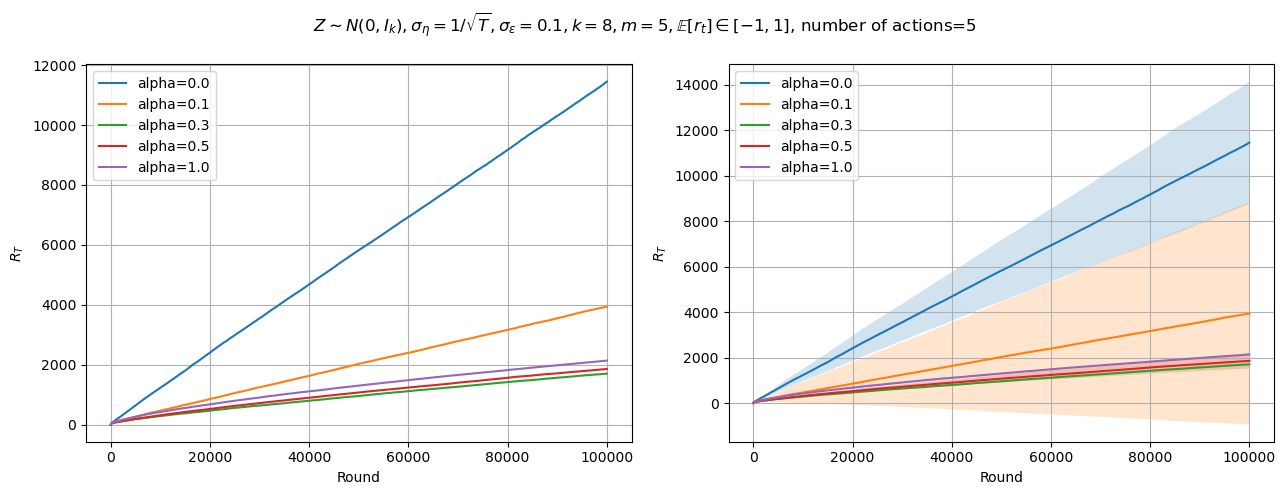

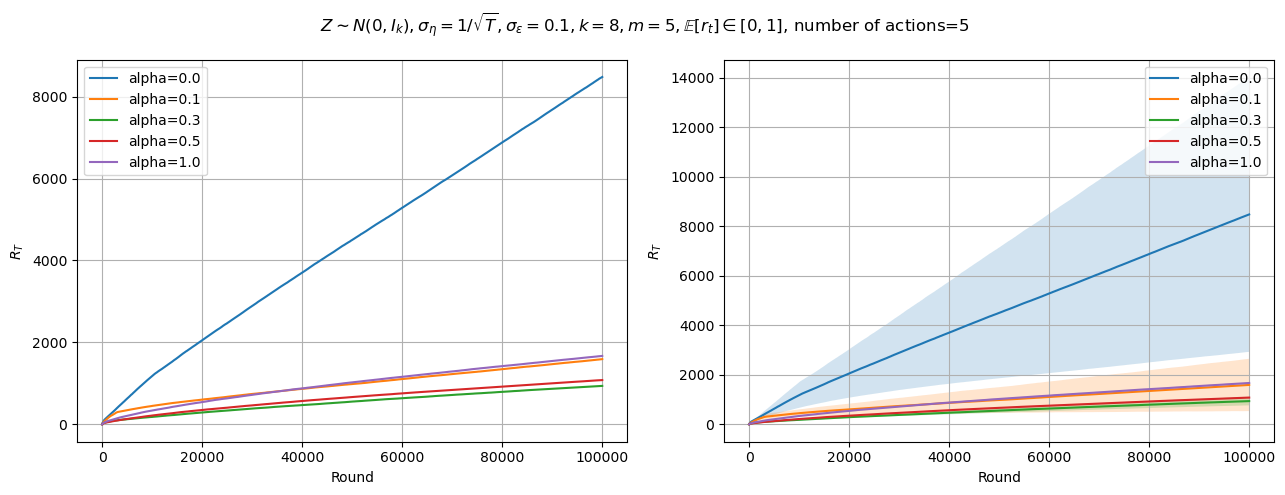

In [23]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result1.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result1.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1/\sqrt{T}, \sigma_\epsilon=0.1, k=8, m=5, \mathbb{E}[r_t]\in [-1, 1]$, number of actions=5")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result2.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result2.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1/\sqrt{T}, \sigma_\epsilon=0.1, k=8, m=5, \mathbb{E}[r_t]\in [0, 1]$, number of actions=5")
plt.tight_layout()
plt.show()

In [29]:
num_arm_list = [3, 5, 10, 15, 20]
true_param = param_generator(dimension=m, distribution="uniform", disjoint=True, random_state=SEED, bound=param_bound)

result = dict()
for num_arms in num_arm_list:
    print(f"number_of_arms={num_arms}")
    inherent_rewards = param_generator(dimension=N, distribution="uniform", disjoint=True, random_state=SEED)
    print(f"Inherent reward for each arm: {inherent_rewards}\tshape: {inherent_rewards.shape}\tnorm: {l2norm(inherent_rewards)}")

    print(f"When expected reward is bounded in [0, {reward_bound}]")
    result_container = []
    for trial in range(runtime):
        agent = PartialLinUCB(d=d, N=N, alpha=1.0)
        regret = run(agent=agent, num_actions=N, num_visibles=m, horizon=T, obs=X, latents=Z, true_params=true_param, inherent_rewards=inherent_rewards,
                     reward_bound=reward_bound, noise_std=0.1, symmetric=False)
        result_container.append(np.cumsum(regret))
    result[num_arms] = np.array(result_container)
        
plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}, ")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1/\sqrt{T}, \sigma_\epsilon=0.1, k=8, m=5, \mathbb{E}[r_t]\in [0, 1]$")
plt.tight_layout()
plt.show()

number_of_arms=3
Inherent reward for each arm: [ 8.87700416e-01 -8.22911944e-01  3.90741935e-01  3.99980705e-01
 -7.99310297e-04]	shape: (5,)	norm: 1.3333643761349934
When expected reward is bounded in [0, 1.0]


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

number_of_arms=5
Inherent reward for each arm: [ 8.87700416e-01 -8.22911944e-01  3.90741935e-01  3.99980705e-01
 -7.99310297e-04]	shape: (5,)	norm: 1.3333643761349934
When expected reward is bounded in [0, 1.0]


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

number_of_arms=10
Inherent reward for each arm: [ 8.87700416e-01 -8.22911944e-01  3.90741935e-01  3.99980705e-01
 -7.99310297e-04]	shape: (5,)	norm: 1.3333643761349934
When expected reward is bounded in [0, 1.0]


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [31]:
result

{3: array([[0.00000000e+00, 1.00000000e+00, 1.61119312e+00, ...,
         1.67055769e+03, 1.67055769e+03, 1.67055769e+03],
        [5.08449750e-02, 3.89145271e-01, 3.89145271e-01, ...,
         1.69021394e+03, 1.69021394e+03, 1.69021394e+03],
        [6.11395349e-01, 1.61139535e+00, 1.97500270e+00, ...,
         1.67962911e+03, 1.67962911e+03, 1.67962911e+03],
        [6.52747503e-01, 1.56857032e+00, 1.92615392e+00, ...,
         1.66510617e+03, 1.66510617e+03, 1.66510617e+03]]),
 5: array([[0.00000000e+00, 1.00000000e+00, 1.61119312e+00, ...,
         1.67055769e+03, 1.67055769e+03, 1.67055769e+03],
        [5.08449750e-02, 3.89145271e-01, 3.89145271e-01, ...,
         1.69021394e+03, 1.69021394e+03, 1.69021394e+03],
        [6.11395349e-01, 1.61139535e+00, 1.97500270e+00, ...,
         1.67962911e+03, 1.67962911e+03, 1.67962911e+03],
        [6.52747503e-01, 1.56857032e+00, 1.92615392e+00, ...,
         1.66510617e+03, 1.66510617e+03, 1.66510617e+03]])}

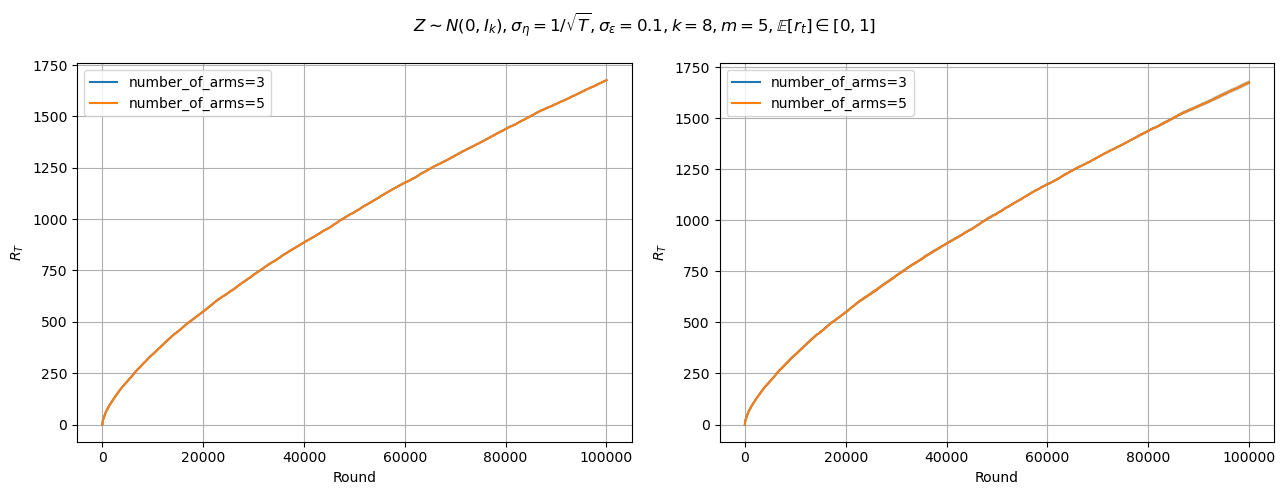

In [32]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"number_of_arms={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"number_of_arms={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1/\sqrt{T}, \sigma_\epsilon=0.1, k=8, m=5, \mathbb{E}[r_t]\in [0, 1]$")
plt.tight_layout()
plt.show()